# Introduction to Monte Carlo Simulation in Finance

## Example: A Crude Simulation of a Call Option Price under the Black-Scholes Model

Ref.: *Don L. McLeish* **Monte Carlo Simulation and Finance** Wiley

<img src="img/cover_mcleish.jpg" width="10%" align="left" border="0">

In [2]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl


It's worth to recast the pricing problem into a simple integral formulation in order to gain some insight into the general problem;
\item So let's consider again the payoff of a simple plain vanilla option
$$e^{-rT} \mathbb{E^Q} [ h(S_T) ] = e^{-rT} \mathbb{E^Q} \left[ h \left( S_0 e^{\log(S_T/S_0)} \right) \right]$$

By a simple application of Ito's lemma is easy to demonstrate that the variable $X = \log(S_T/S_0)$ has a normal distribution with mean $m=(r-\frac{1}{2} \sigma^2)T$ and variance $s=\sigma^2T$.

So we can write
$$ C(S,t)= e^{-rT}S_0 \int\limits_0^{+\infty} \max[ e^X-K,0] e^{-\frac{(X-m)^2}{2s^2}} dX  $$

Let's now recall the fundamental **probability integral transform** which relates to the result that data values that are modelled as being random variables from any given continuous distribution can be converted to random variables having a uniform distribution

This result states that if a random variable $X$ has a continuous distribution for which the cumulative distribution function (CDF) is $F_X$. Then the random variable $Y$ defined as

$$ Y = F_X(X)$$

has a uniform distribution;

This means that, in our case, we can say that the variable

$$u = \Phi[X;m,u], \quad u\rightarrow 1 \, when \, X \rightarrow +\infty$$

has a uniform distribution;

From the previous relation we find (within a normalization factor)

$$du = \frac{d\Phi[X;m,u]}{dX} dX  \Rightarrow dX = \frac{1}{e^{-\frac{(X-m)^2}{2s^2}}}du$$

Finally we can write our integral in the form

$$
C(S,t) = \int\limits_0^1 f(u) du$$
where $f(u) = e^{-rT} \max[S_0 \exp(\Phi^{-1}(u; m,s)) - K,0] $

In [3]:
def f(u, S0, K, r, sigma, T):
    m      = (r - .5*sigma*sigma)*T
    s      = sigma*sqrt(T)
    f_u    = exp(-r*T)*np.maximum(S0*exp(scnorm.ppf(u, m, s))-K,0)
    return f_u    

where scnorm.ppf is the [inverse of cumulative normal](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.norm.html)

We recall the Black and Scholes formulas from the pricing of Call and Put Options...

$C(S(t)) = S(t)N(d_1)-Ke^{-r(T-t)}N(d_2)$

$P(S(t)) = Ke^{-r(T-t)}N(-d_2) - S(t)N(-d_1)$

where

$d_1=\frac{\log(S(t)/K)+(r+\sigma^2/2}{\sigma \sqrt{T}}$ 

$d_2 = d_1 - \sigma \sqrt{T}$

In [4]:
def BlackSholes(CallPutFlag,S,X,T,r,v):
    d1 = (log(S/X)+(r+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if CallPutFlag=='c':
        return S*scnorm.cdf(d1)-X*exp(-r*T)*scnorm.cdf(d2)
    else:
        return X*exp(-r*T)*scnorm.cdf(-d2)-S*scnorm.cdf(-d1)

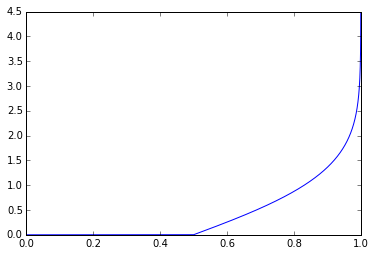

In [8]:

S0     = 10
K      = 10
r      = 0.02
T      = 0.25
sigma  = 0.2


u      = np.linspace(0, 1, 10000)
f_u    = f(u,S0,K,r,sigma,T)

pl.plot(u, f_u)
pl.show()


In [6]:
print BlackSholes('c',S0,K,T,r,sigma)

0.423215976807


In [9]:
u      = rand(1000000)
f_u    = f(u,S0,K,r,sigma,T)

print mean(f_u)

0.422541651147
